<a href="https://colab.research.google.com/github/rsadaphule/jhu-aaml/blob/main/JHU_AAML_Module_5_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
MNIST_DATA_FOLDER = '/content/drive/My Drive/JHU/AAML/Assignments/data/MNIST/raw/'
FASHION_MNIST_DATA_FOLDER = '/content/drive/My Drive/JHU/AAML/Assignments/data/FashionMNIST/raw/'
GAN_OUTPUT_FOLDER = '/content/drive/My Drive/JHU/AAML/Assignments/data/gan_output/'



In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision

print(f'PyTorch version= {torch.__version__}')
print(f'torchvision version= {torchvision.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')

PyTorch version= 2.0.1+cu118
torchvision version= 0.15.2+cu118
CUDA available= True


In [4]:
if torch.cuda.is_available():
    # CUDA Installation
    print('CUDA Version')
    !nvcc --version
    print()

    # CUDNN Installation
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')

CUDA Version
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0

CUDNN Version: 8700
Number of CUDA Devices: 1
Active CUDA Device: 0
Available devices: 1, Name: Tesla V100-SXM2-16GB
Current CUDA device: 0


In [5]:
import sys

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as vtransforms
import torchvision.utils as vutils

import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # Might benefit if the nnet instance remains same

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hide some PyTorch warnings (bugs)
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Initialize conv layers with N(0,0.02), batch norm layers N(1,0.02) and 0 bias
def init_weights(_m):
    if isinstance(_m, nn.Conv2d) or isinstance(_m, nn.ConvTranspose2d):
        torch.nn.init.normal_(_m.weight, mean=0.0, std=0.02)
    if isinstance(_m, nn.BatchNorm2d):
        torch.nn.init.normal_(_m.weight, mean=1.0, std=0.02)
        _m.bias.data.fill_(0.0)

In [7]:
# Get the training and testing datasets from a path with resize and normalization
def get_dataloader(_img_size, _bs, _ds, _path):
    train_ds = _ds(
        root=_path, download=False, train=True,
        transform=vtransforms.Compose([
            vtransforms.Resize(_img_size),
            vtransforms.ToTensor(),
            vtransforms.Normalize((0.5,), (0.5,))
        ]))

    # Use pin_memory=True to fix GPU memory
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=_bs, shuffle=True,
                                           #pin_memory=True,
                                           num_workers=4)

    test_ds = _ds(
        root=_path, download=False, train=False,
        transform=vtransforms.Compose([
            vtransforms.Resize(_img_size),
            vtransforms.ToTensor(),
            vtransforms.Normalize((0.5,), (0.5,))
        ]))

    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=_bs, shuffle=True,
                                          #pin_memory=True,
                                          num_workers=4)

    return train_dl, test_dl

# Requires data files to be under MNIST/raw at the root location
# i.e. ../../../EP_datasets/mnist/MNIST/raw
def get_dl_mnist(_img_size, _bs):
    return get_dataloader(_img_size, _bs, dset.MNIST, MNIST_DATA_FOLDER)

# Requires data files to be under MNIST/raw at the root location
# i.e. ../../../EP_datasets/fashionmnist/FashionMNIST/raw
def get_dl_fashionmnist(_img_size, _bs):
    return get_dataloader(_img_size, _bs, dset.FashionMNIST, FASHION_MNIST_DATA_FOLDER )

In [8]:
%%time

info= True
EPOCHS= 7
ETA= 1e-3

IMG_SIZE= 28
BATCH_SIZE= 5000

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


### GAN Example

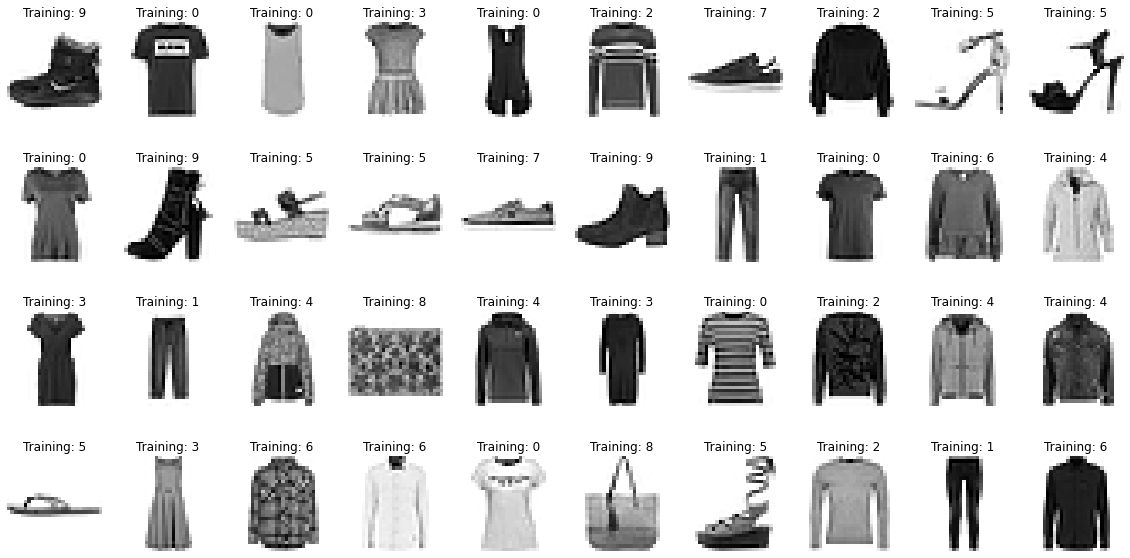

In [9]:
train_dl2, test_dl2 = get_dl_fashionmnist(IMG_SIZE, BATCH_SIZE)

# Draw the first 40 data points - in this case a single data point is an image
plt.figure(1, figsize=(20, 10), dpi=72)
for index in range(40):
    image, label = train_dl2.dataset[index]
    plt.subplot(4, 10, index+1)
    plt.axis('off')
    plt.imshow(image[0].numpy(), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Training: {label}')

In [10]:
# Lists to store losses
losses_G_standard = []
losses_D_standard = []
losses_G_wgan = []
losses_D_wgan = []

In [11]:
D_HIDDEN= 64
IMG_CHANNEL= 1  # color channel
MLP_HIDDEN= 16  # Hidden layer size


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(

            nn.Conv2d(IMG_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(D_HIDDEN, D_HIDDEN*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(D_HIDDEN*2, D_HIDDEN*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(D_HIDDEN*4, D_HIDDEN*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(D_HIDDEN*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, _input):
        return self.net(_input).view(-1, 1).squeeze(1)

# Check the network layers
print(Discriminator())

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
G_HIDDEN= 64
Z_DIM= 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(

            nn.ConvTranspose2d(Z_DIM, G_HIDDEN*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN*8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(G_HIDDEN*8, G_HIDDEN*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(G_HIDDEN*4, G_HIDDEN*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(G_HIDDEN*2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(G_HIDDEN, IMG_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, _input):
        return self.net(_input)

# Check the network layers
print(Generator())

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [13]:
%%time

X_DIM= 64
BATCH_SIZE= 1000

train_dl, test_dl = get_dl_fashionmnist(X_DIM, BATCH_SIZE)

# Create the Discriminator and place it in gpu
netD = Discriminator().to(device)
netD.apply(init_weights)

# Create the Generator and place it in gpu
netG = Generator().to(device)
netG.apply(init_weights)

# Optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=ETA, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=ETA, betas=(0.5, 0.999))

info= True
EPOCHS= 50

# Learning the real and fake - reminder this is not a classification problem
REAL_LABEL= 1
FAKE_LABEL= 0

# Same noise sample to generate the sample fake
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

for e in range(EPOCHS):
    for i, data in enumerate(train_dl):
        x_real = data[0].to(device)
        real_label = torch.full((x_real.size(0),), REAL_LABEL, dtype=torch.float32, device=device)
        fake_label = torch.full((x_real.size(0),), FAKE_LABEL, dtype=torch.float32, device=device)

        # Update D with real data
        netD.zero_grad()
        y_real = netD(x_real)
        loss_D_real = criterion(y_real, real_label)
        loss_D_real.backward()

        # Update D with fake data
        z_noise = torch.randn(x_real.size(0), Z_DIM, 1, 1, device=device)
        x_fake = netG(z_noise)
        y_fake = netD(x_fake.detach())
        loss_D_fake = criterion(y_fake, fake_label)
        loss_D_fake.backward()
        optimizerD.step()

        loss_D = loss_D_fake + loss_D_real

        # Update G with fake data
        netG.zero_grad()
        y_fake_r = netD(x_fake)
        loss_G = criterion(y_fake_r, real_label)
        loss_G.backward()
        optimizerG.step()
        losses_G_standard.append(loss_G.item())
        losses_D_standard.append(loss_D.item())

        if info:
            sys.stderr.write("\r{:03d}/{:3d} | LossDr: {:6.2f} | lossDf: {:6.2f} | lossG: {:6.2f}".format(
                e+1, EPOCHS, loss_D_real.mean().item(), loss_D_fake.mean().item(), loss_G.mean().item()))
            sys.stderr.flush()

            if i == 0:
                with torch.no_grad():
                    viz_sample = netG(viz_noise)
                    vutils.save_image(vutils.make_grid(viz_sample[:32], nrow=4),
                                      GAN_OUTPUT_FOLDER + f'fake_samples_{e}.png', normalize=True)

    if info:
        torch.save(netG.state_dict(), GAN_OUTPUT_FOLDER +  f'netG_{e}.pth')
        torch.save(netD.state_dict(), GAN_OUTPUT_FOLDER + f'netD_{e}.pth')

050/ 50 | LossDr:   0.01 | lossDf:   0.74 | lossG:   4.84

CPU times: user 13min 40s, sys: 26.2 s, total: 14min 6s
Wall time: 15min 38s


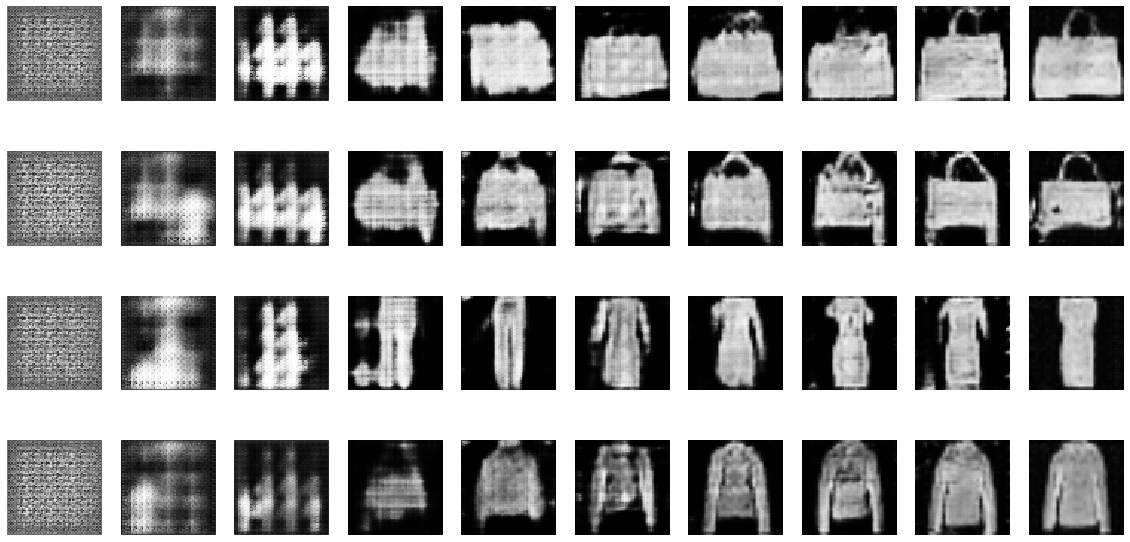

In [14]:
# Draw stored fake epochs
def draw_strip(_row, _col, _offset):
    # epoch
    ix = (0, 1, 2, 5, 10, 15, 20, 25, 30, EPOCHS-1)
    # position excluding the grid
    def img_xy(x, y):
        return 2*(x+1)+64*x, 2*(y+1)+64*y

    x, y = img_xy(_row,_col)
    for i, e in enumerate(ix):
        img = plt.imread(GAN_OUTPUT_FOLDER + f'fake_samples_{e}.png')
        plt.subplot(4, 10, 10*_offset + i+1)
        plt.axis('off')
        plt.imshow(img[x:x+64,y:y+64], cmap=plt.cm.gray_r, interpolation='nearest')

plt.figure(1, figsize=(20, 10), dpi=72)
draw_strip(0,0,0)
draw_strip(1,0,1)
draw_strip(2,2,2)
draw_strip(3,0,3)

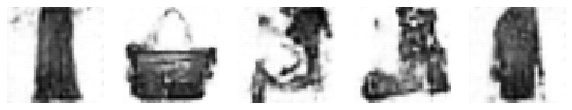

In [15]:
# Load saved weights, generate a fake image
netG2 = Generator()
netG2.load_state_dict(torch.load(GAN_OUTPUT_FOLDER + f'netG_{EPOCHS-1:d}.pth'))
netG2.to(device)

plt.figure(1, figsize=(10, 5), dpi=72)
for i in range(5):
    plt.subplot(1, 5, i+1)
    with torch.no_grad():
        x_fake = netG2(torch.randn(1, Z_DIM, 1, 1, device=device))
    plt.axis('off')
    plt.imshow(x_fake.to('cpu').numpy().reshape(64,64), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

Let's analyze the learning speed of GAN and WGAN networks, how fast they converge while
they are learning to create fake images. Feel free to use a smaller dataset such as MNIST, or
CIFAR-10, or make it small by removing certain classes from the dataset. Update the GAN
module to create a Wasserstein GAN. Note that we are following the Arjovsky 2017 paper.
1. [80 pts]
• Update the loss function for a Wasserstein GAN.
• Update the optimizers if necessary.
• Remove the sigmoid.
• Update the critic to run a few times more than the generator.
• Use a variable clip-weight (e.g. 0.01) to update and clip the weights of the critic between
[-clip-weight, +clip-weight].



Ans -
The Wasserstein GAN (WGAN) introduces a new loss function that helps to stabilize the training of GANs. Here's a brief overview of the changes required to convert a standard GAN to a WGAN:

1. **Loss Function**:
   - In the standard GAN, the discriminator tries to classify real and fake samples using the sigmoid cross-entropy loss. In WGAN, the discriminator (often referred to as the critic in WGAN terminology) tries to find the Wasserstein distance between real and generated distributions. The loss functions are updated as follows:
     - For the discriminator/critic: \( Loss_{Critic} = Mean(D(G(z))) - Mean(D(x)) \)
     - For the generator: \( Loss_{Generator} = -Mean(D(G(z))) \)

2. **Clipping Weights**:
   - To ensure that the critic is a 1-Lipschitz function, the weights of the critic are clipped to a small fixed range, typically [-0.01, 0.01].

3. **No Log in the Loss**:
   - Unlike the standard GAN, we don't take the logarithm of the losses in WGAN.

4. **Training the Critic More**:
   - Typically, the critic is updated more frequently than the generator (e.g., 5 critic updates for every generator update).


Here's updated code for a Wasserstein GAN:



In [16]:
D_HIDDEN= 64
IMG_CHANNEL= 1  # color channel
MLP_HIDDEN= 16  # Hidden layer size


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(

            nn.Conv2d(IMG_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(D_HIDDEN, D_HIDDEN*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(D_HIDDEN*2, D_HIDDEN*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(D_HIDDEN*4, D_HIDDEN*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(D_HIDDEN*8, 1, 4, 1, 0, bias=False),
            #nn.Sigmoid()
        )
    def forward(self, _input):
        return self.net(_input).view(-1, 1).squeeze(1)

# Check the network layers
print(Discriminator())

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [17]:
losses_G_wgan = []
losses_D_wgan = []

## Loss FUnction Update
### Variable clip-weight (e.g. 0.01) to update and clip the weights of the critic between [-clip-weight, +clip-weight].
### Loss Function:

In the standard GAN, the discriminator tries to classify real and fake samples using the sigmoid cross-entropy loss. In WGAN, the discriminator (often referred to as the critic in WGAN terminology) tries to find the Wasserstein distance between real and generated distributions. The loss functions are updated as follows:
For the discriminator/critic: ( Loss_{Critic} = Mean(D(G(z))) - Mean(D(x)) )
For the generator: ( Loss_{Generator} = -Mean(D(G(z))) )

In [18]:
CRITIC_ITERATIONS = 5  # Number of critic updates per generator update

for e in range(EPOCHS):
    for i, data in enumerate(train_dl):

        ############################
        # (1) Update Critic: maximize E[D(x)] - E[D(G(z))]
        ###########################
        for _ in range(CRITIC_ITERATIONS):
            netD.zero_grad()

            # Train with all-real batch
            x_real = data[0].to(device)
            D_real = netD(x_real)
            D_real_mean = D_real.mean()

            # Train with all-fake batch
            z_noise = torch.randn(x_real.size(0), Z_DIM, 1, 1, device=device)
            x_fake = netG(z_noise)
            D_fake = netD(x_fake.detach())
            D_fake_mean = D_fake.mean()

            # WGAN loss for the critic
            loss_D = D_fake_mean - D_real_mean
            loss_D.backward()

            optimizerD.step()

            losses_D_wgan.append(loss_D.item())

            # Clipping weights for 1-Lipschitz continuity
            for p in netD.parameters():
                p.data.clamp_(-0.01, 0.01)

        ############################
        # (2) Update Generator: maximize E[D(G(z))]
        ###########################
        netG.zero_grad()

        z_noise = torch.randn(x_real.size(0), Z_DIM, 1, 1, device=device)
        x_fake = netG(z_noise)
        D_fake_r = netD(x_fake)

        # WGAN loss for the generator
        loss_G = -D_fake_r.mean()
        loss_G.backward()

        optimizerG.step()
        losses_G_wgan.append(loss_G.item())
        # Print training stats
        if info:
            sys.stderr.write("\r{:03d}/{:3d} | LossD: {:6.2f} | LossG: {:6.2f}".format(
                e+1, EPOCHS, loss_D.item(), loss_G.item()))
            sys.stderr.flush()

    # Save generator's output after every epoch
    if info:
        with torch.no_grad():
            viz_sample = netG(viz_noise)
            vutils.save_image(vutils.make_grid(viz_sample[:32], nrow=4),
                              GAN_OUTPUT_FOLDER + f'fake_samples_{e}.png', normalize=True)

        # Save model checkpoints
        torch.save(netG.state_dict(), GAN_OUTPUT_FOLDER +  f'netG_{e}.pth')
        torch.save(netD.state_dict(), GAN_OUTPUT_FOLDER + f'netD_{e}.pth')


050/ 50 | LossD:  -0.07 | LossG:  -0.46

2. [20 pts] Empirically show that the WGAN converges faster than a GAN.

### Analysis
### Lets Compare Loss Curves for GAN and WGAN side by side

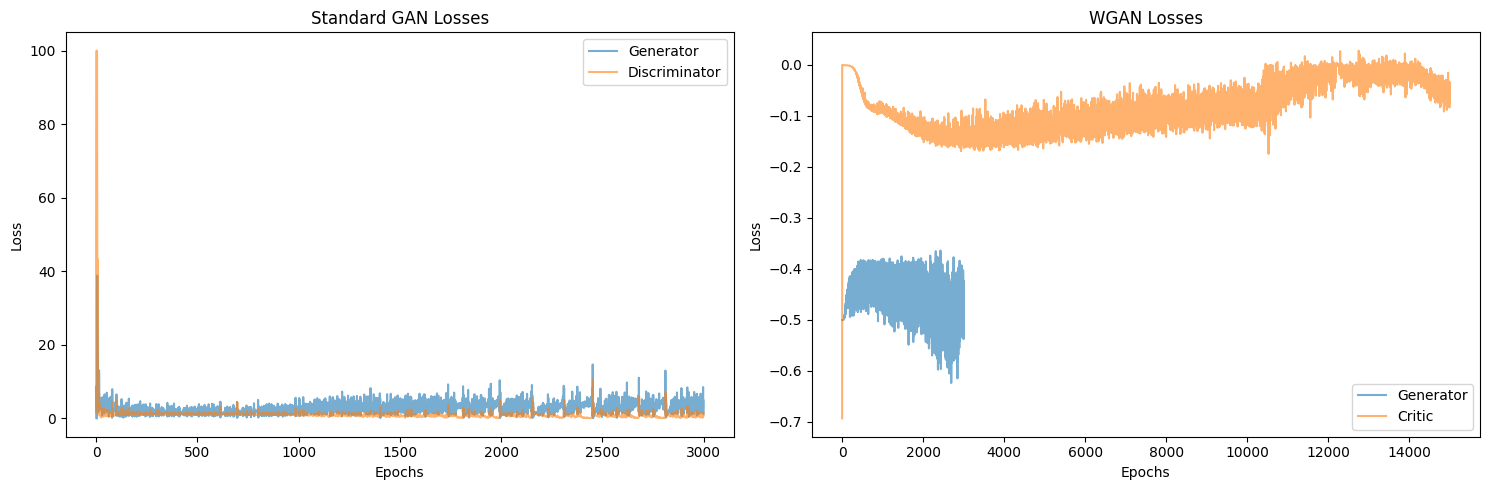

In [19]:
import matplotlib.pyplot as plt

# Plotting the Generator and Discriminator loss for both GANs
plt.figure(figsize=(15, 5))

# Standard GAN Losses
plt.subplot(1, 2, 1)
plt.plot(losses_G_standard, label="Generator", alpha=0.6)
plt.plot(losses_D_standard, label="Discriminator", alpha=0.6)
plt.title("Standard GAN Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# WGAN Losses
plt.subplot(1, 2, 2)
plt.plot(losses_G_wgan, label="Generator", alpha=0.6)
plt.plot(losses_D_wgan, label="Critic", alpha=0.6)
plt.title("WGAN Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


This code displays two plots side by side. The left plot shows the losses for the standard GAN, and the right plot shows the losses for the WGAN.

* As you can see in case of stabdard GAN the discriminator and generator loss variation is much lower than corresponding WGAN discriminator and generator. In a WGAN, the generator tries to maximize the critic's score for its outputs. Since the critic in WGAN is not bounded between [0, 1] (unlike the discriminator in a standard GAN), the scores can vary more widely. This can lead to more variation in the generator's loss. Additionally, the Wasserstein distance provides smoother gradients, which can result in more noticeable updates to the generator, leading to more variation in the loss.

* Since Critic is updated more frequently than Generator in WGAN, it exhauts its epochs sooner than generator

* While the generator loss in a standard GAN might appear more stable, it doesn't necessarily mean the GAN is training better. The vanishing gradient problem in standard GANs can lead to mode collapse, where the generator produces limited varieties of samples. On the other hand, the WGAN, despite having a more varying loss, often results in a more diverse set of generated samples and is generally more stable in training.

